# Modelling

code for our models they include an SVM, K nearst neighbour and XGBoost models as well as their ensemble. THE SVM is our baseline, specifically all data with the original level and no level balancing is our baseline model

# Installing Packages

In [18]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install yellowbrick
!{sys.executable} -m pip install matplot
!{sys.executable} -m pip install seaborn

# Preprocessing of Data

In [19]:
import os
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer

import copy

# Helper function: simply reads a csv file and return it as a dataframe
def read_data(data_file):
  data_df = pd.read_csv(data_file)
  return data_df

def drop_features(data_df, features_to_drop):
  return data_df.drop(columns=features_to_drop, inplace=True)

def segregate_noisy_data(data_df):
  copied_data = copy.deepcopy(data_df)
  non_noisy_df = copied_data.loc[(copied_data['noisy_train'] == 0)]
  noisy_df = copied_data.loc[(copied_data['noisy_train'] == 1)]
  return non_noisy_df, noisy_df

def remove_noisy_data(data_df):
  print(f'''Rows dropped because of low duration: 
        {len(data_df[data_df['noisy'] == 1])}\n''')
  
  return data_df.drop(data_df[data_df['noisy'] == 1].index, inplace=True)

# Helper function: cleans data based on xyz
def preprocessing_data(data_df):

  # Clean data based on duration value
  print(f'''Rows dropped because of low duration: \
        {len(data_df[data_df['duration'] < 2])}\n''')
  
  data_df.drop(data_df[data_df['duration'] < 2].index, inplace=True)

  # Extract filenames
  filenames = data_df['file_name'].values.tolist()

  return (data_df, filenames)


Read Data

In [20]:
# Fetch .csv file and store it as a dataframe
aggression_data_df = read_data('../extracted/full-train-features.csv')

Extract data, filenames and labels after preprocessing data

In [21]:
print(f'Shape of the data before cleaning it: {aggression_data_df.shape}\n')
print(aggression_data_df.tail())

aggression_data_df, filenames = preprocessing_data(aggression_data_df)

print(f'Shape of the data after cleaning it: {aggression_data_df.shape} \n')

Shape of the data before cleaning it: (2146, 23)

                      file_name  duration  analyse_harmonics  \
2141  xdz15thrnem51_processed_5      10.0           5.465491   
2142  xdz15thrnem51_processed_6      10.0           6.879443   
2143  xdz15thrnem51_processed_7      10.0           4.468770   
2144  xdz15thrnem51_processed_8      10.0           8.581945   
2145  xdz15thrnem51_processed_9      10.0           2.829222   

      get_number_sylls  get_number_words  pauses  get_max_intensity  \
2141               1.3               1.0     0.1         104.113896   
2142               0.2               0.3     0.1         108.028173   
2143               1.8               1.1     0.1         104.678268   
2144               0.3               0.1     0.1         109.335715   
2145               0.6               0.6     0.1         105.455598   

      analyse_intensity  analyse_pitch  analyse_pitch_range  ...  \
2141          69.550541     199.893943           443.057705  ...   
21

Segregate data based on noisy vs not noisy

In [22]:
non_noisy_df, noisy_df = segregate_noisy_data(aggression_data_df)

print(f"Shape of noisy data: {noisy_df.shape} \n")
print(f"Shape of non noisy data: {non_noisy_df.shape}\n")

Shape of noisy data: (262, 23) 

Shape of non noisy data: (1849, 23)



**NOTE: Modelling of this project is split into 3 groups. Therefore, all the steps in this notebook below are repeated once for each group**
1. Noisy and Non Noisy Data
2. Noisy Data
3. Non Noisy Data

Drop features

In [23]:
features_to_drop = ['file_name', 'duration','get_number_sylls',
                    'get_number_words', 'pauses',
                    'number_of_segments_train', 'number_of_voices_parent_train',
                    'extra_sounds_train', 'Notes_train']

# remove features for Group 1
print(f'Shape of the data for Group 1 before dropping features: {aggression_data_df.shape} \n')
drop_features(aggression_data_df, features_to_drop)

# remove features for Group 2
print(f'Shape of the data for Group 2 before dropping features: {non_noisy_df.shape} \n')
drop_features(non_noisy_df, features_to_drop)

# remove features for Group 3
print(f'Shape of the data for Group 3 before dropping features: {noisy_df.shape} \n')
drop_features(noisy_df, features_to_drop)


print(f'Shape of the data for Group 1 after dropping features: {aggression_data_df.shape} \n')
print(f'Shape of the data for Group 2 after dropping features: {non_noisy_df.shape} \n')
print(f'Shape of the data for Group 3 after dropping features: {noisy_df.shape} \n')

Shape of the data for Group 1 before dropping features: (2111, 23) 

Shape of the data for Group 2 before dropping features: (1849, 23) 

Shape of the data for Group 3 before dropping features: (262, 23) 

Shape of the data for Group 1 after dropping features: (2111, 14) 

Shape of the data for Group 2 after dropping features: (1849, 14) 

Shape of the data for Group 3 after dropping features: (262, 14) 



### Examine dataframe from each group

In [24]:
print(aggression_data_df.info())
print(non_noisy_df.info())
print(noisy_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2111 entries, 0 to 2145
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   analyse_harmonics      2111 non-null   float64
 1   get_max_intensity      2111 non-null   float64
 2   analyse_intensity      2111 non-null   float64
 3   analyse_pitch          2110 non-null   float64
 4   analyse_pitch_range    2110 non-null   float64
 5   analyse_shimmer        2110 non-null   float64
 6   analyse_jitter         2110 non-null   float64
 7   spectral_slope         2111 non-null   float64
 8   mean_spectral_rolloff  2111 non-null   float64
 9   get_energy             2111 non-null   float64
 10  parent_file_train      2111 non-null   object 
 11  parent_label_train     2111 non-null   int64  
 12  segment_label_train    2111 non-null   int64  
 13  noisy_train            2111 non-null   int64  
dtypes: float64(10), int64(3), object(1)
memory usage: 247.4+

Remove rows that have `NaN` as one of the feature values

1 row in both group 1 and group 2 have `NaN`

In [25]:
aggression_data_df.dropna(inplace=True)
non_noisy_df.dropna(inplace=True)
noisy_df.dropna(inplace=True)


Convert values in 'get_max_intensity' from string to float 

In [26]:
aggression_data_df['get_max_intensity'] = pd.to_numeric(aggression_data_df['get_max_intensity'])
non_noisy_df['get_max_intensity'] = pd.to_numeric(non_noisy_df['get_max_intensity'])
noisy_df['get_max_intensity'] = pd.to_numeric(noisy_df['get_max_intensity'])

noisy_df.head(15)

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,2.071884,108.591944,76.429126,355.354649,517.899150,0.193371,0.039075,-0.091534,1711.357507,0.174962,00g8dfgpqpt61,0,0,1
1,1.548685,107.108480,78.207339,409.030438,491.537960,0.202199,0.049623,-0.090760,1469.373610,0.263521,00g8dfgpqpt62,0,0,1
2,2.202973,110.003934,77.650102,393.605328,511.080779,0.200674,0.038352,-0.116676,1287.538989,0.231453,00g8dfgpqpt63,0,0,1
3,4.541632,100.037201,67.432142,358.021668,448.489253,0.201583,0.035544,-0.010975,1251.558111,0.022047,01avx2fm1t961,3,3,1
4,3.790801,98.041081,63.570349,373.512829,519.744413,0.190743,0.046422,-0.004044,1387.495977,0.009121,01avx2fm1t961,3,2,1
5,3.859515,99.656235,66.680578,394.698825,461.355272,0.181399,0.038183,-0.011376,1164.256959,0.018612,01avx2fm1t961,3,2,1
6,4.301706,100.620469,67.893825,355.316875,439.101386,0.199342,0.043200,-0.014285,1043.864847,0.025372,01avx2fm1t961,3,2,1
7,4.134565,101.666306,68.782272,381.025067,513.486703,0.192137,0.038323,-0.017456,1025.571987,0.028210,01avx2fm1t961,3,2,1
64,4.832865,108.258940,77.036272,219.231909,499.293824,0.173476,0.024539,-0.089942,1778.052375,0.139028,09etqbnf0uc61,0,0,1
88,3.707670,107.282961,77.338457,107.077688,523.583154,0.161535,0.027049,-0.157909,903.503189,0.216111,0cho11mt05y51,0,0,1


Segregate data df and label df and reset indexes from all groups

In [27]:
feature_labels = ['parent_label_train', 'segment_label_train', 'noisy_train']

label_df = aggression_data_df.filter(items=feature_labels)
aggression_df = aggression_data_df#.drop(columns=feature_labels)

label_non_noisy_df = non_noisy_df.filter(items=feature_labels)
aggression_non_noisy_df = non_noisy_df#.drop(columns=feature_labels)

label_noisy_df = noisy_df.filter(items=feature_labels)
aggression_noisy_df = noisy_df#.drop(columns=feature_labels)

label_df.reset_index(drop=True, inplace=True)
aggression_df.reset_index(drop=True, inplace=True)

label_non_noisy_df.reset_index(drop=True, inplace=True)
aggression_non_noisy_df.reset_index(drop=True, inplace=True)

label_noisy_df.reset_index(drop=True, inplace=True)
aggression_noisy_df.reset_index(drop=True, inplace=True)

print(f"Shape of labelled data in Group 1:{label_df.shape} \n Shape of data in Group 1: {aggression_df.shape}\n")
print(f"Shape of labelled data in Group 2:{label_non_noisy_df.shape} \n Shape of data in Group 2: {aggression_non_noisy_df.shape}\n")
print(f"Shape of labelled data in Group 3:{label_noisy_df.shape} \n Shape of data in Group 3: {aggression_noisy_df.shape}\n")

Shape of labelled data in Group 1:(2110, 3) 
 Shape of data in Group 1: (2110, 14)

Shape of labelled data in Group 2:(1848, 3) 
 Shape of data in Group 2: (1848, 14)

Shape of labelled data in Group 3:(262, 3) 
 Shape of data in Group 3: (262, 14)



Extra code to run model against parent labels and not segment labels

In [28]:
aggression_df #label_df

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,2.071884,108.591944,76.429126,355.354649,517.899150,0.193371,0.039075,-0.091534,1711.357507,0.174962,00g8dfgpqpt61,0,0,1
1,1.548685,107.108480,78.207339,409.030438,491.537960,0.202199,0.049623,-0.090760,1469.373610,0.263521,00g8dfgpqpt62,0,0,1
2,2.202973,110.003934,77.650102,393.605328,511.080779,0.200674,0.038352,-0.116676,1287.538989,0.231453,00g8dfgpqpt63,0,0,1
3,4.541632,100.037201,67.432142,358.021668,448.489253,0.201583,0.035544,-0.010975,1251.558111,0.022047,01avx2fm1t961,3,3,1
4,3.790801,98.041081,63.570349,373.512829,519.744413,0.190743,0.046422,-0.004044,1387.495977,0.009121,01avx2fm1t961,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,5.465491,104.113896,69.550541,199.893943,443.057705,0.196757,0.033226,-0.020890,1002.676098,0.036482,xdz15thrnem51,2,1,0
2106,6.879443,108.028173,75.501002,258.536830,379.915372,0.149580,0.024206,-0.081411,1023.670363,0.141290,xdz15thrnem51,2,2,0
2107,4.468770,104.678268,71.100226,194.904220,493.340814,0.162628,0.034465,-0.028155,980.207236,0.051732,xdz15thrnem51,2,1,0
2108,8.581945,109.335715,76.784989,285.988051,520.259229,0.149758,0.022509,-0.108299,1146.211888,0.190454,xdz15thrnem51,2,2,0


In [29]:
# print(aggression_noisy_df.tail(10))

to_add = aggression_noisy_df.parent_file_train.unique()

actual_noisy_test_df = pd.DataFrame(to_add, columns = ['filename'])
actual_noisy_test_df["parent_label"] = -1

actual_noisy_test_df.head()

for fn in to_add:    
    actual_noisy_test_df.loc[actual_noisy_test_df['filename'] == fn, ['parent_label']] = noisy_df.loc[noisy_df.parent_file_train == fn, 'parent_label_train'].values[0]
    # actual_noisy_test_df.at[0, fn] = aggression_noisy_df.iloc[0][fn]

actual_noisy_test_df
# print(noisy_df.loc[noisy_df.parent_file_train == '3nvn1lwacgg61', 'parent_label_train'].values[0])

,filename,parent_label
0,00g8dfgpqpt61,0
1,00g8dfgpqpt62,0
2,00g8dfgpqpt63,0
3,01avx2fm1t961,3
4,09etqbnf0uc61,0
...,...,...
69,wjha1sf516b71,0
70,wkgibcp6fro51,0
71,wocoyi48sgs51,2
72,xbw64yf04th51,1


# Standardization

In [30]:
from sklearn.preprocessing import StandardScaler

# Helper function: returns a standardized dataframe
def standardize(df):
    org_features = df.columns
    features = [i for i in df.columns if i not in ['parent_file_train'] + feature_labels]
    
    values_array = df.loc[:, features].values

    # Print data before standardization to compare
    print("Before Standardization \n")
    print("Mean and Standard Deviation")
    print(f"Mean = {np.mean(values_array)} ; Standard Deviation = {np.std(values_array)}")
    print(f"Shape to verify: {values_array.shape} \n")
    print(f"Tail of the data pre standardization: \n{values_array[-5:]} \n\n")

    # Invoke standardization
    # Numeric columns: Std scaler
    pipeline = ColumnTransformer([
        ('transform_numeric',StandardScaler(),features),    
    ], remainder='passthrough')


    # Transform input vector (features)
    df =  pd.DataFrame(pipeline.fit_transform(df),columns=org_features)
    
    #values_array = StandardScaler().fit_transform(values_array)
    
    values_array = df.loc[:, features].values  # To do the below computation
    # Print data after standardization to compare
    print("After Standardization \n")
    print("Mean and Standard Deviation")
    print(f"Mean = {np.mean(values_array)} ; Standard Deviation = {np.std(values_array)}")
    print(f"Shape to verify: {values_array.shape}")
    print(f"Tail of the data post standardization: \n{values_array[-5:]}")

    return df

Standardize data for all groups

In [31]:
standardized_aggression_df = standardize(aggression_df)
standardized_non_noisy_df = standardize(aggression_non_noisy_df)
standardized_noisy_df = standardize(aggression_noisy_df)

Before Standardization 

Mean and Standard Deviation
Mean = 207.03214462485482 ; Standard Deviation = 405.89809500083527
Shape to verify: (2110, 10) 

Tail of the data pre standardization: 
[[ 5.46549109e+00  1.04113896e+02  6.95505405e+01  1.99893943e+02
   4.43057705e+02  1.96756913e-01  3.32257430e-02 -2.08904800e-02
   1.00267610e+03  3.64816420e-02]
 [ 6.87944281e+00  1.08028173e+02  7.55010015e+01  2.58536830e+02
   3.79915372e+02  1.49580347e-01  2.42058080e-02 -8.14106130e-02
   1.02367036e+03  1.41290270e-01]
 [ 4.46876994e+00  1.04678268e+02  7.11002256e+01  1.94904220e+02
   4.93340814e+02  1.62627554e-01  3.44649850e-02 -2.81549870e-02
   9.80207236e+02  5.17316800e-02]
 [ 8.58194493e+00  1.09335715e+02  7.67849889e+01  2.85988051e+02
   5.20259229e+02  1.49757852e-01  2.25093080e-02 -1.08298994e-01
   1.14621189e+03  1.90454480e-01]
 [ 2.82922212e+00  1.05455598e+02  7.46545323e+01  1.86190085e+02
   4.86287854e+02  1.95173250e-01  3.43624990e-02 -8.18768770e-02
   6.98359

In [32]:
standardized_aggression_df

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,-1.229415,0.816248,0.877741,1.42237,0.857657,0.898334,0.355641,-0.331514,0.907009,0.498579,00g8dfgpqpt61,0,0,1
1,-1.369057,0.541133,1.180279,2.008275,0.626936,1.131041,1.008834,-0.322634,0.438397,1.124945,00g8dfgpqpt62,0,0,1
2,-1.194428,1.078107,1.085473,1.8399,0.79798,1.090856,0.310873,-0.620007,0.086267,0.898132,00g8dfgpqpt63,0,0,1
3,-0.570238,-0.770265,-0.652971,1.451482,0.250161,1.114803,0.136983,0.592854,0.016588,-0.582963,01avx2fm1t961,3,3,1
4,-0.770635,-1.140454,-1.310001,1.620578,0.873807,0.829075,0.810602,0.672384,0.279838,-0.674388,01avx2fm1t961,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,-0.323659,-0.014225,-0.292555,-0.274583,0.202622,0.987592,-0.006539,0.479082,-0.465383,-0.480872,xdz15thrnem51,2,1,0
2106,0.053725,0.711694,0.719834,0.365542,-0.350018,-0.25594,-0.565074,-0.215352,-0.424726,0.260425,xdz15thrnem51,2,2,0
2107,-0.589685,0.09044,-0.028897,-0.329049,0.642715,0.087973,0.070198,0.395726,-0.508895,-0.37301,xdz15thrnem51,2,1,0
2108,0.508124,0.954183,0.938286,0.665189,0.878313,-0.251261,-0.670125,-0.523881,-0.187419,0.608156,xdz15thrnem51,2,2,0


# Modelling

In [33]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import svm, mixture
from sklearn.model_selection import GridSearchCV, train_test_split

def hyperparameter_tuning(ml_model, data, label, parameters):
    clf = GridSearchCV(ml_model, parameters, refit=True, verbose=0, scoring='f1_weighted', n_jobs=-1, error_score='raise')
    clf.fit(data, label)
    print(clf.best_params_)

def run_model(ml_model, data, label, label_name):
    model = copy.deepcopy(ml_model)
    
    # Only train on this feature set
    feature_set = data.drop(['parent_file_train']+feature_labels,axis=1).columns  # Only these features will be fed to the model
    print('Feature set:',feature_set)
    
    actual_labels = np.empty([0], dtype=int)
    predicted_labels = np.empty([0], dtype=int)

    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.25)
    
    
    model.fit(X_train[feature_set], y_train)
    y_pred = model.predict(X_test[feature_set])
    
    X_test['segment_predictions'] = y_pred  # To store prediction with rest of the data
    #X_test['segment_actual'] = y_test  # To store prediction with rest of the data

    actual_labels = np.append(actual_labels, y_test)
    predicted_labels = np.append(predicted_labels, y_pred)

    acc_score = accuracy_score(y_test, y_pred)
    prec_score = precision_score(y_test, y_pred, average='weighted')
    rec_score = recall_score(y_test, y_pred, average='weighted')
    fone_score = f1_score(y_test, y_pred, average='weighted')

    print(f'F1 score = {fone_score}; Accuracy score = {acc_score} ; Precisison Score = {prec_score}; Recall score = {rec_score}')

    return actual_labels, predicted_labels, X_test

def confusion_matrix_graph(model_name, actual_labels, predicted_labels, label_names):
    matrix = confusion_matrix(actual_labels, predicted_labels)

    plt.figure(figsize=(14, 8))
    ax = sns.heatmap(matrix, annot=True, xticklabels=label_names, yticklabels=label_names, cmap="Greens")
    ax.set_title(model_name);
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual');

    print("\n\n Aggregate report \n", classification_report(actual_labels, predicted_labels, target_names=label_names))

    plt.show()    



Convert dataframes to numpy array

In [34]:
standardized_aggression_df

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,-1.229415,0.816248,0.877741,1.42237,0.857657,0.898334,0.355641,-0.331514,0.907009,0.498579,00g8dfgpqpt61,0,0,1
1,-1.369057,0.541133,1.180279,2.008275,0.626936,1.131041,1.008834,-0.322634,0.438397,1.124945,00g8dfgpqpt62,0,0,1
2,-1.194428,1.078107,1.085473,1.8399,0.79798,1.090856,0.310873,-0.620007,0.086267,0.898132,00g8dfgpqpt63,0,0,1
3,-0.570238,-0.770265,-0.652971,1.451482,0.250161,1.114803,0.136983,0.592854,0.016588,-0.582963,01avx2fm1t961,3,3,1
4,-0.770635,-1.140454,-1.310001,1.620578,0.873807,0.829075,0.810602,0.672384,0.279838,-0.674388,01avx2fm1t961,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,-0.323659,-0.014225,-0.292555,-0.274583,0.202622,0.987592,-0.006539,0.479082,-0.465383,-0.480872,xdz15thrnem51,2,1,0
2106,0.053725,0.711694,0.719834,0.365542,-0.350018,-0.25594,-0.565074,-0.215352,-0.424726,0.260425,xdz15thrnem51,2,2,0
2107,-0.589685,0.09044,-0.028897,-0.329049,0.642715,0.087973,0.070198,0.395726,-0.508895,-0.37301,xdz15thrnem51,2,1,0
2108,0.508124,0.954183,0.938286,0.665189,0.878313,-0.251261,-0.670125,-0.523881,-0.187419,0.608156,xdz15thrnem51,2,2,0


In [35]:
data_np = standardized_aggression_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_np = label_df['segment_label_train'].to_numpy()

data_non_noisy_np = standardized_non_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_non_noisy_np = label_non_noisy_df['segment_label_train'].to_numpy()

data_noisy_np = standardized_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_noisy_np = label_noisy_df['segment_label_train'].to_numpy()

/var/folders/7b/v9yf5j856tggrfg1tm641t9c0000gn/T/ipykernel_23664/2163191907.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_np = standardized_aggression_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
/var/folders/7b/v9yf5j856tggrfg1tm641t9c0000gn/T/ipykernel_23664/2163191907.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_non_noisy_np = standardized_non_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
/var/folders/7b/v9yf5j856tggrfg1tm641t9c0000gn/T/ipykernel_23664/2163191907.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_noisy_np = standardized_noisy_df.drop(["parent_file_train", "pa

## SVM

Hyperparameter Tuning for SVM

In [ ]:
# original_parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': ['scale', 'auto'],
#                    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1,2,3,4,5,6]}

quick_parameters = {'C': [ 0.001, 0.01, 0.1, 1, 10, 100], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
hyperparameter_tuning(svc, data_np, label_np, quick_parameters)
hyperparameter_tuning(svc, data_non_noisy_np, label_non_noisy_np, quick_parameters)
hyperparameter_tuning(svc, data_noisy_np, label_noisy_np, quick_parameters)

Results from hyper parameter tuning for SVM using `original_parameters`: **`{'C': 1, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}`**

***NOTE: `orginal_parameters` were the actual parameters against which the parameters were tuned. However, the results took over 4 hours to be processed. Therefore, `quick_parameters` is just a smaller subset of the `original_parameters`.***

{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Run SVM model

## Group 1 (All data) is our baseline for segments

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.5416363138646112; Accuracy score = 0.5568181818181818 ; Precisison Score = 0.5512002751777957; Recall score = 0.5568181818181818


 Aggregate report 
               precision    recall  f1-score   support

           0       0.65      0.78      0.71       235
           1       0.50      0.48      0.49       145
           2       0.29      0.27      0.28        85
           3       0.65      0.27      0.38        63

    accuracy                           0.56       528
   macro avg       0.52      0.45      0.47       528
weighted avg       0.55      0.56      0.54       528



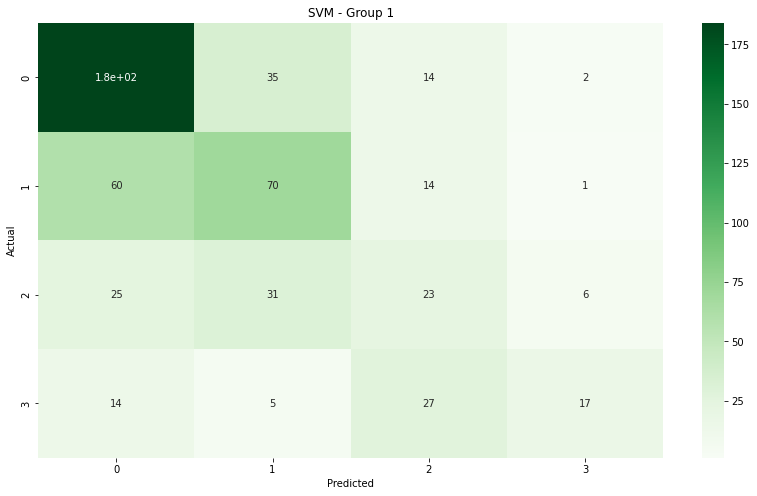

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.5669503012142729; Accuracy score = 0.5714285714285714 ; Precisison Score = 0.5965329014541454; Recall score = 0.5714285714285714


 Aggregate report 
               precision    recall  f1-score   support

           0       0.62      0.72      0.67       177
           1       0.52      0.53      0.52       157
           2       0.47      0.46      0.47        82
           3       1.00      0.35      0.52        46

    accuracy                           0.57       462
   macro avg       0.65      0.51      0.54       462
weighted avg       0.60      0.57      0.57       462



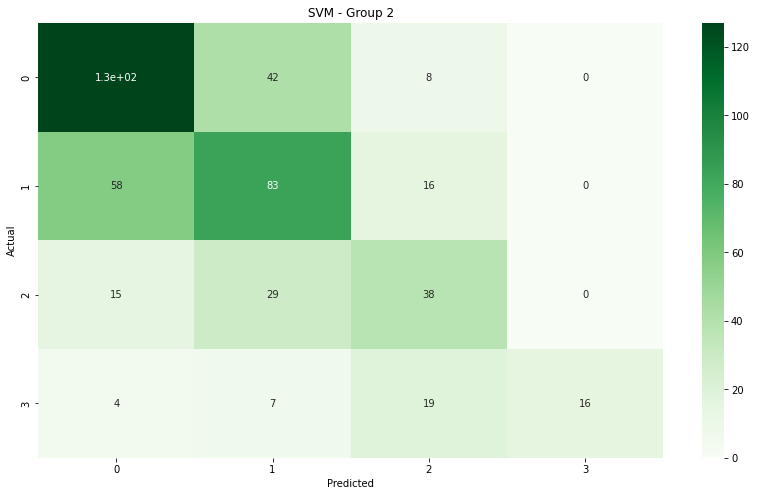

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6493166963755197; Accuracy score = 0.7121212121212122 ; Precisison Score = 0.5978685478059695; Recall score = 0.7121212121212122


 Aggregate report 
               precision    recall  f1-score   support

           0       0.77      0.95      0.85        38
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         7
           3       0.65      0.69      0.67        16

    accuracy                           0.71        66
   macro avg       0.35      0.41      0.38        66
weighted avg       0.60      0.71      0.65        66



c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, 

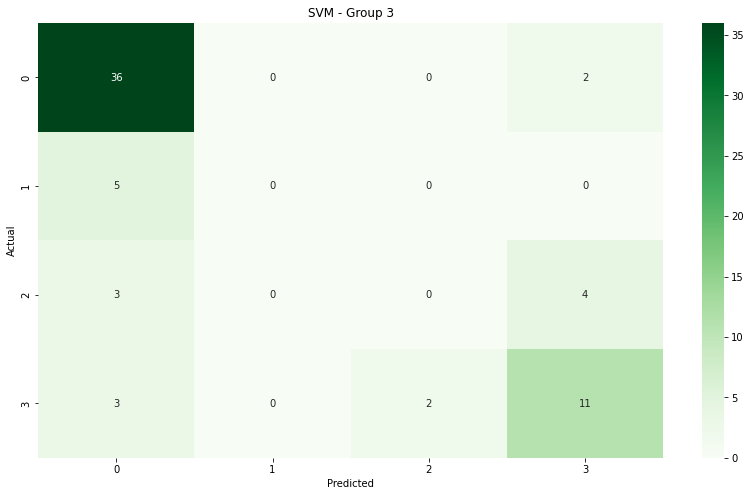

In [121]:
#lst_data_np = [data_np, data_non_noisy_np, data_noisy_np]
lst_label_np = [label_np, label_non_noisy_np, label_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df, standardized_non_noisy_df, standardized_noisy_df]
X_test_list = [None,None,None]
gamma = ['auto', 'scale', 'auto']
c = [1, 10, 1]

for i in range(3):
    svm_model = svm.SVC(kernel='rbf', gamma=gamma[i], C=c[i])
    actual, predicted, X_test_list[i] = run_model(svm_model, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"SVM - Group {i+1}", actual, predicted, ['0', '1', '2', '3'])

#### Parent label analysis

## Group 1 (All data) is our baseline for Parent



 Aggregate report 
               precision    recall  f1-score   support

           0       0.47      0.70      0.56        69
           1       0.29      0.25      0.27        51
           2       0.19      0.20      0.19        41
           3       0.62      0.23      0.33        44

    accuracy                           0.39       205
   macro avg       0.39      0.34      0.34       205
weighted avg       0.40      0.39      0.37       205



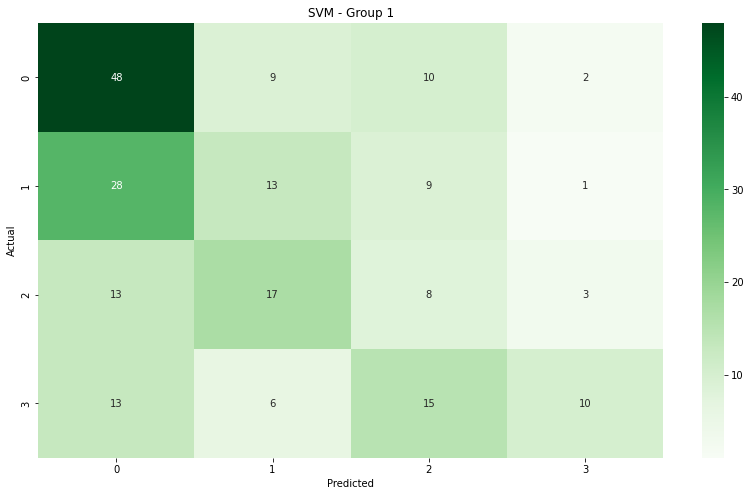



 Aggregate report 
               precision    recall  f1-score   support

           0       0.55      0.68      0.61        53
           1       0.33      0.40      0.36        50
           2       0.41      0.41      0.41        44
           3       1.00      0.23      0.37        31

    accuracy                           0.46       178
   macro avg       0.57      0.43      0.44       178
weighted avg       0.53      0.46      0.45       178



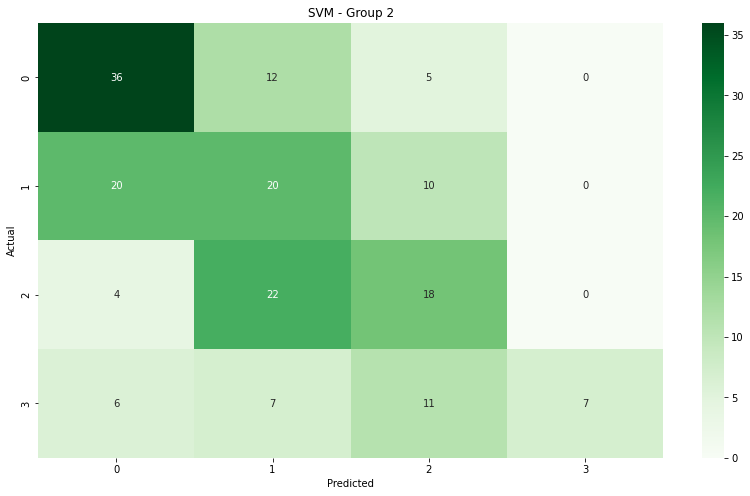



 Aggregate report 
               precision    recall  f1-score   support

           0       0.59      1.00      0.74        17
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         3
           3       0.82      0.64      0.72        14

    accuracy                           0.62        42
   macro avg       0.35      0.41      0.36        42
weighted avg       0.51      0.62      0.54        42



c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

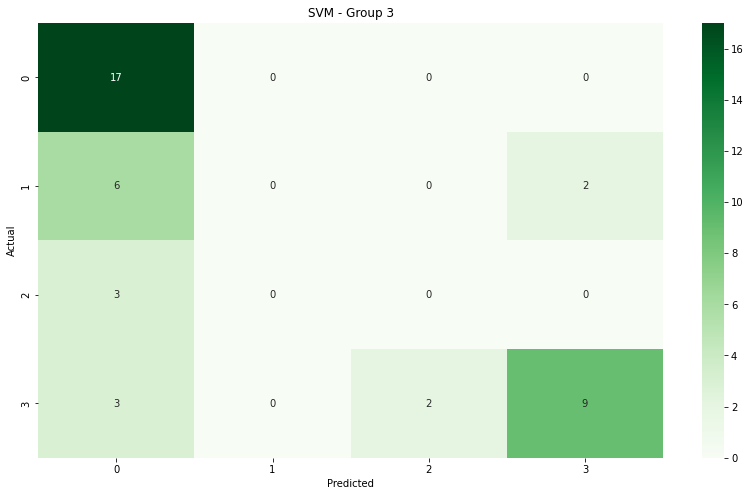

,parent_file_train,parent_label_train,segment_predictions
0,01avx2fm1t961,3,2
1,0202on89vhz61,0,1
2,03mglec8fez51,1,1
3,0653ipqy7vd71,2,0
4,08ss0a3zs0061,2,0
...,...,...,...
200,x705shsub7m61,1,0
201,xbw64yf04th51,1,0
202,xc76oggvh2471,1,2
203,xdz15thrnem51,2,2


In [122]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

max_parent_df_list[0]

### Test combining level 1 and level 2 as they appear to have difficulty classifying

In [21]:
standardized_aggression_df

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,-1.229415,0.816248,0.877741,1.42237,0.857657,0.898334,0.355641,-0.331514,0.907009,0.498579,00g8dfgpqpt61,0,0,1
1,-1.369057,0.541133,1.180279,2.008275,0.626936,1.131041,1.008834,-0.322634,0.438397,1.124945,00g8dfgpqpt62,0,0,1
2,-1.194428,1.078107,1.085473,1.8399,0.79798,1.090856,0.310873,-0.620007,0.086267,0.898132,00g8dfgpqpt63,0,0,1
3,-0.570238,-0.770265,-0.652971,1.451482,0.250161,1.114803,0.136983,0.592854,0.016588,-0.582963,01avx2fm1t961,3,3,1
4,-0.770635,-1.140454,-1.310001,1.620578,0.873807,0.829075,0.810602,0.672384,0.279838,-0.674388,01avx2fm1t961,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,-0.323659,-0.014225,-0.292555,-0.274583,0.202622,0.987592,-0.006539,0.479082,-0.465383,-0.480872,xdz15thrnem51,2,1,0
2106,0.053725,0.711694,0.719834,0.365542,-0.350018,-0.25594,-0.565074,-0.215352,-0.424726,0.260425,xdz15thrnem51,2,2,0
2107,-0.589685,0.09044,-0.028897,-0.329049,0.642715,0.087973,0.070198,0.395726,-0.508895,-0.37301,xdz15thrnem51,2,1,0
2108,0.508124,0.954183,0.938286,0.665189,0.878313,-0.251261,-0.670125,-0.523881,-0.187419,0.608156,xdz15thrnem51,2,2,0


combine the labels in all dataframes

In [36]:
standardized_aggression_mergedlabels_df = standardized_aggression_df.copy()
standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 2, 'segment_label_train' ] = 1
standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 3, 'segment_label_train'] = 2
standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['parent_label_train'] == 2, 'parent_label_train'] = 1
standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['parent_label_train'] == 3, 'parent_label_train'] = 2
print(standardized_aggression_mergedlabels_df['segment_label_train'].unique())
print(standardized_aggression_mergedlabels_df['parent_label_train'].unique())

[0 2 1]
[0 2 1]


In [37]:
standardized_mergedlabels_non_noisy_df = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['noisy_train'] == 0]
standardized_mergedlabels_noisy_df = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['noisy_train'] == 1]

convert to numpy arrays

In [38]:
data_merged_np = standardized_aggression_mergedlabels_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_merged_np = standardized_aggression_mergedlabels_df['segment_label_train'].to_numpy()
label_merged_np=label_merged_np.astype('int')

data_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df['segment_label_train'].to_numpy()
label_merged_non_noisy_np=label_merged_non_noisy_np.astype('int')

data_merged_noisy_np = standardized_mergedlabels_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_merged_noisy_np = standardized_mergedlabels_noisy_df['segment_label_train'].to_numpy()
label_merged_noisy_np=label_merged_noisy_np.astype('int')

/var/folders/7b/v9yf5j856tggrfg1tm641t9c0000gn/T/ipykernel_23664/2370931604.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_merged_np = standardized_aggression_mergedlabels_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
/var/folders/7b/v9yf5j856tggrfg1tm641t9c0000gn/T/ipykernel_23664/2370931604.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
/var/folders/7b/v9yf5j856tggrfg1tm641t9c0000gn/T/ipykernel_23664/2370931604.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_merged_noisy_np = stand

Get new hyper params

In [182]:
quick_parameters = {'C': [ 0.001, 0.01, 0.1, 1, 10, 100], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
hyperparameter_tuning(svc, data_merged_np, label_merged_np, quick_parameters)
hyperparameter_tuning(svc, data_merged_non_noisy_np, label_merged_non_noisy_np, quick_parameters)
hyperparameter_tuning(svc, data_merged_noisy_np, label_merged_noisy_np, quick_parameters)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6542990896571458; Accuracy score = 0.6571969696969697 ; Precisison Score = 0.6567046612918173; Recall score = 0.6571969696969697


 Aggregate report 
               precision    recall  f1-score   support

           0       0.68      0.66      0.67       224
           1       0.64      0.70      0.67       253
           2       0.62      0.41      0.49        51

    accuracy                           0.66       528
   macro avg       0.65      0.59      0.61       528
weighted avg       0.66      0.66      0.65       528



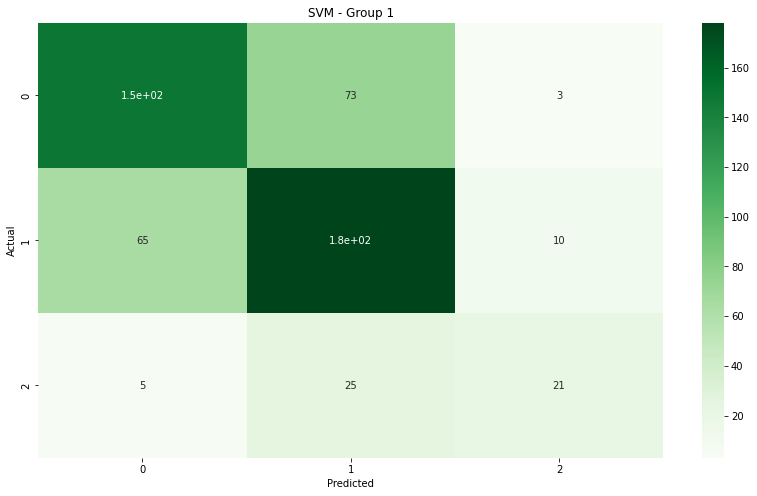

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6550345443361341; Accuracy score = 0.6623376623376623 ; Precisison Score = 0.6809816371845502; Recall score = 0.6623376623376623


 Aggregate report 
               precision    recall  f1-score   support

           0       0.70      0.62      0.66       205
           1       0.63      0.76      0.69       222
           2       0.91      0.29      0.43        35

    accuracy                           0.66       462
   macro avg       0.75      0.56      0.59       462
weighted avg       0.68      0.66      0.66       462



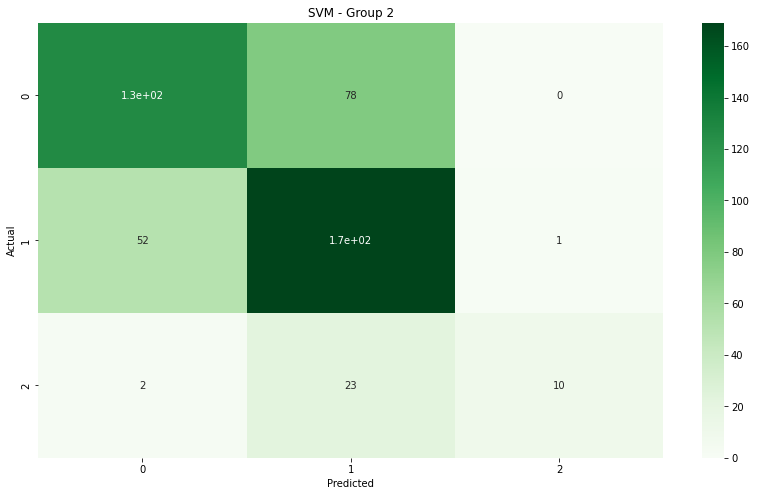

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.5103238962393892; Accuracy score = 0.5757575757575758 ; Precisison Score = 0.4678753989098816; Recall score = 0.5757575757575758


 Aggregate report 
               precision    recall  f1-score   support

           0       0.73      0.79      0.76        34
           1       0.00      0.00      0.00        16
           2       0.38      0.69      0.49        16

    accuracy                           0.58        66
   macro avg       0.37      0.49      0.42        66
weighted avg       0.47      0.58      0.51        66



c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, 

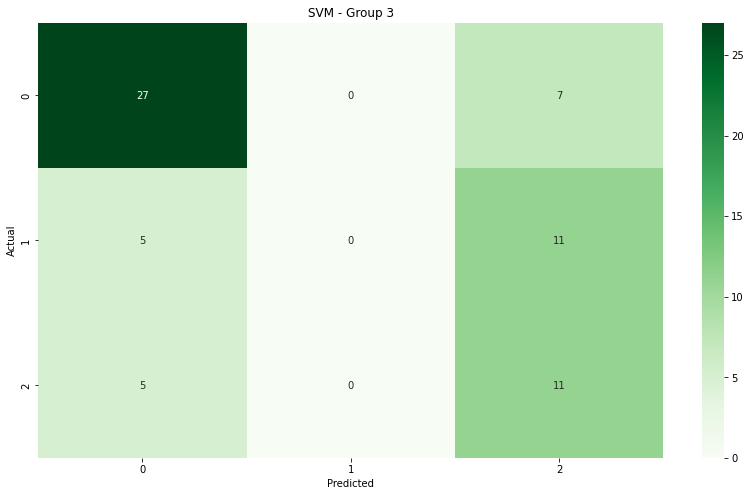

In [189]:
lst_label_np = [label_merged_np, label_merged_non_noisy_np, label_merged_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_mergedlabels_df, standardized_mergedlabels_non_noisy_df, standardized_mergedlabels_noisy_df]
X_test_list = [None,None,None]
kernel = ['rbf', 'rbf', 'linear']
c = [10, 10, 0.1]

for i in range(3):
    svm_model = svm.SVC(kernel=kernel[i], gamma='scale', C=c[i])
    actual, predicted, X_test_list[i] = run_model(svm_model, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"SVM - Group {i+1}", actual, predicted, ['0', '1', '2'])

Improvements in all but noisy, it seems to still not be able to predict anything but the extreme classes



 Aggregate report 
               precision    recall  f1-score   support

           0       0.55      0.57      0.56        63
           1       0.61      0.73      0.67       100
           2       0.77      0.40      0.52        43

    accuracy                           0.61       206
   macro avg       0.65      0.57      0.58       206
weighted avg       0.63      0.61      0.60       206



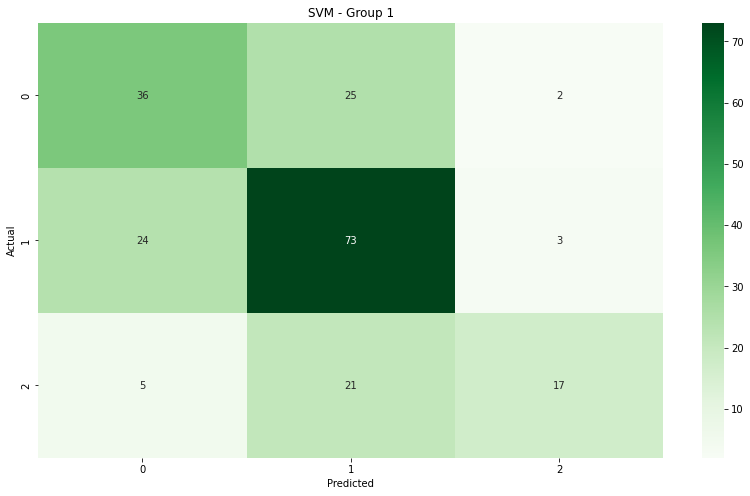



 Aggregate report 
               precision    recall  f1-score   support

           0       0.58      0.62      0.60        47
           1       0.63      0.81      0.71        88
           2       1.00      0.18      0.31        33

    accuracy                           0.63       168
   macro avg       0.74      0.54      0.54       168
weighted avg       0.69      0.63      0.60       168



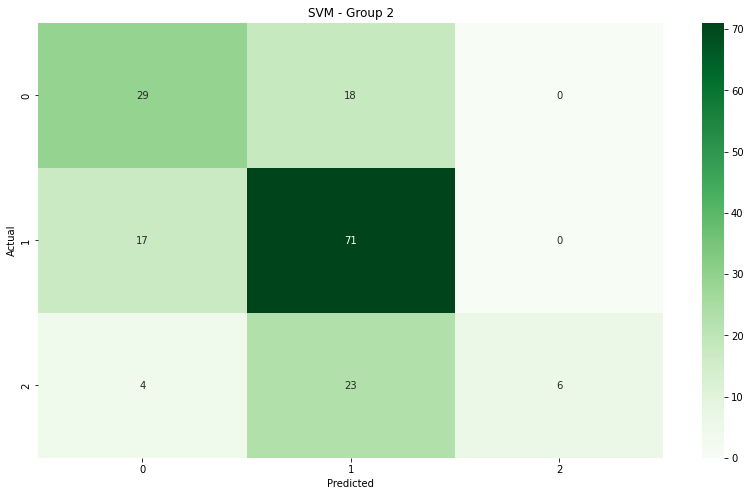



 Aggregate report 
               precision    recall  f1-score   support

           0       0.65      0.72      0.68        18
           1       0.00      0.00      0.00        10
           2       0.56      1.00      0.71        10

    accuracy                           0.61        38
   macro avg       0.40      0.57      0.47        38
weighted avg       0.45      0.61      0.51        38



c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

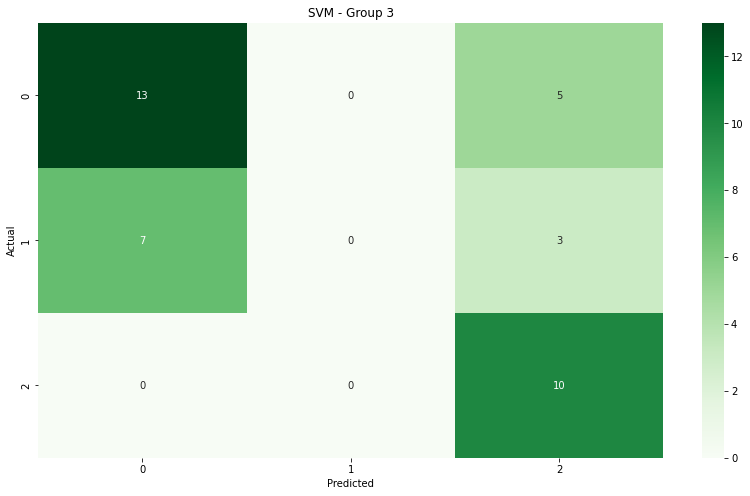

,parent_file_train,parent_label_train,segment_predictions
0,01avx2fm1t961,2,1
1,0202on89vhz61,0,1
2,03mglec8fez51,1,1
3,0653ipqy7vd71,1,1
4,095x9borh0z61,1,1
...,...,...,...
201,wspxs1zbhm671,1,1
202,wunn1jjbpu961,0,0
203,wunqa6kfsvx51,0,0
204,xdz15thrnem51,1,1


In [191]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2'])

max_parent_df_list[0] 

again we see improvements

### Try balancing levels with 4 classes

In [39]:
from sklearn.utils import resample

In [40]:
standardized_aggression_df

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,-1.229415,0.816248,0.877741,1.42237,0.857657,0.898334,0.355641,-0.331514,0.907009,0.498579,00g8dfgpqpt61,0,0,1
1,-1.369057,0.541133,1.180279,2.008275,0.626936,1.131041,1.008834,-0.322634,0.438397,1.124945,00g8dfgpqpt62,0,0,1
2,-1.194428,1.078107,1.085473,1.8399,0.79798,1.090856,0.310873,-0.620007,0.086267,0.898132,00g8dfgpqpt63,0,0,1
3,-0.570238,-0.770265,-0.652971,1.451482,0.250161,1.114803,0.136983,0.592854,0.016588,-0.582963,01avx2fm1t961,3,3,1
4,-0.770635,-1.140454,-1.310001,1.620578,0.873807,0.829075,0.810602,0.672384,0.279838,-0.674388,01avx2fm1t961,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,-0.323659,-0.014225,-0.292555,-0.274583,0.202622,0.987592,-0.006539,0.479082,-0.465383,-0.480872,xdz15thrnem51,2,1,0
2106,0.053725,0.711694,0.719834,0.365542,-0.350018,-0.25594,-0.565074,-0.215352,-0.424726,0.260425,xdz15thrnem51,2,2,0
2107,-0.589685,0.09044,-0.028897,-0.329049,0.642715,0.087973,0.070198,0.395726,-0.508895,-0.37301,xdz15thrnem51,2,1,0
2108,0.508124,0.954183,0.938286,0.665189,0.878313,-0.251261,-0.670125,-0.523881,-0.187419,0.608156,xdz15thrnem51,2,2,0


In [41]:
#check initial size
print(standardized_aggression_df.shape)

(2110, 14)


In [42]:
# Separate classes
level0 = standardized_aggression_df.loc[standardized_aggression_df['segment_label_train'] == 0]
level1 = standardized_aggression_df.loc[standardized_aggression_df['segment_label_train'] == 1]
level2 = standardized_aggression_df.loc[standardized_aggression_df['segment_label_train'] == 2]
level3 = standardized_aggression_df.loc[standardized_aggression_df['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(915, 14)
(612, 14)
(364, 14)
(219, 14)


In [43]:
# Downsample 0 class
level0 = resample(level0, replace=False,n_samples=600)

#level1 is close enough

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=600)

#Upsample 3 class
level3 = resample(level3, replace=True, n_samples=600)

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

# Combine
standardized_aggression_df_balanced = pd.concat([level0, level1, level2, level3])

(600, 14)
(612, 14)
(600, 14)
(600, 14)


check that it is now balanced

In [44]:
print(standardized_aggression_df_balanced.shape)

(2412, 14)


In [45]:
level0 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['segment_label_train'] == 0]
level1 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['segment_label_train'] == 1]
level2 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['segment_label_train'] == 2]
level3 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

#check parent balance

level0 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['parent_label_train'] == 0]
level1 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['parent_label_train'] == 1]
level2 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['parent_label_train'] == 2]
level3 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['parent_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(600, 14)
(612, 14)
(600, 14)
(600, 14)
(355, 14)
(432, 14)
(516, 14)
(1109, 14)


now for non noisy

In [46]:
print(standardized_non_noisy_df.shape)

(1848, 14)


In [47]:
# Separate classes
level0 = standardized_non_noisy_df.loc[standardized_non_noisy_df['segment_label_train'] == 0]
level1 = standardized_non_noisy_df.loc[standardized_non_noisy_df['segment_label_train'] == 1]
level2 = standardized_non_noisy_df.loc[standardized_non_noisy_df['segment_label_train'] == 2]
level3 = standardized_non_noisy_df.loc[standardized_non_noisy_df['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(778, 14)
(593, 14)
(331, 14)
(146, 14)


In [48]:
# Downsample 0 class
level0 = resample(level0, replace=False,n_samples=600)

#level1 is close enough

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=600)

#Upsample 3 class
level3 = resample(level3, replace=True, n_samples=600)

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

# Combine
standardized_non_noisy_df_balanced = pd.concat([level0, level1, level2, level3])

(600, 14)
(593, 14)
(600, 14)
(600, 14)


In [49]:
print(standardized_non_noisy_df_balanced.shape)

(2393, 14)


In [50]:
level0 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['segment_label_train'] == 0]
level1 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['segment_label_train'] == 1]
level2 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['segment_label_train'] == 2]
level3 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

#check parent label balance

level0 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['parent_label_train'] == 0]
level1 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['parent_label_train'] == 1]
level2 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['parent_label_train'] == 2]
level3 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['parent_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(600, 14)
(593, 14)
(600, 14)
(600, 14)
(325, 14)
(432, 14)
(583, 14)
(1053, 14)


now for noisy

In [51]:
print(standardized_noisy_df.shape)

(262, 14)


In [52]:
# Separate classes
level0 = standardized_noisy_df.loc[standardized_noisy_df['segment_label_train'] == 0]
level1 = standardized_noisy_df.loc[standardized_noisy_df['segment_label_train'] == 1]
level2 = standardized_noisy_df.loc[standardized_noisy_df['segment_label_train'] == 2]
level3 = standardized_noisy_df.loc[standardized_noisy_df['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(137, 14)
(19, 14)
(33, 14)
(73, 14)


In [53]:
# Downsample 0 class
level0 = resample(level0, replace=False,n_samples=75)

#Upsample 2 class
level1 = resample(level1, replace=True, n_samples=75)

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=75)

#level3 close enough

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

# Combine
standardized_noisy_df_balanced = pd.concat([level0, level1, level2, level3])

(75, 14)
(75, 14)
(75, 14)
(73, 14)


check

In [54]:
print(standardized_noisy_df_balanced.shape)

(298, 14)


In [55]:
level0 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['segment_label_train'] == 0]
level1 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['segment_label_train'] == 1]
level2 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['segment_label_train'] == 2]
level3 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

#check parent balance 

level0 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['parent_label_train'] == 0]
level1 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['parent_label_train'] == 1]
level2 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['parent_label_train'] == 2]
level3 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['parent_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(75, 14)
(75, 14)
(75, 14)
(73, 14)
(63, 14)
(59, 14)
(31, 14)
(145, 14)


all parents are now more unbalanced, but this should be OK because we are not training on them

rebuild the svm

In [56]:
data_balanced_np = standardized_aggression_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_np = standardized_aggression_df_balanced['segment_label_train'].to_numpy()
label_balanced_np=label_balanced_np.astype('int')

data_balanced_non_noisy_np = standardized_non_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_non_noisy_np = standardized_non_noisy_df_balanced['segment_label_train'].to_numpy()
label_balanced_non_noisy_np=label_balanced_non_noisy_np.astype('int')

data_balanced_noisy_np = standardized_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_noisy_np = standardized_noisy_df_balanced['segment_label_train'].to_numpy()
label_balanced_noisy_np=label_balanced_noisy_np.astype('int')

/var/folders/7b/v9yf5j856tggrfg1tm641t9c0000gn/T/ipykernel_23664/917994061.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_balanced_np = standardized_aggression_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
/var/folders/7b/v9yf5j856tggrfg1tm641t9c0000gn/T/ipykernel_23664/917994061.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_balanced_non_noisy_np = standardized_non_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
/var/folders/7b/v9yf5j856tggrfg1tm641t9c0000gn/T/ipykernel_23664/917994061.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_balanced_noisy_np = standardiz

#### SVC

In [313]:
# original_parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': ['scale', 'auto'],
#                    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1,2,3,4,5,6]}

quick_parameters = {'C': [1000, 10000,100000], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
hyperparameter_tuning(svc, data_balanced_np, label_balanced_np, quick_parameters)

{'C': 100000, 'gamma': 'auto', 'kernel': 'rbf'}


In [305]:
quick_parameters = {'C': [100, 1000, 10000], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
hyperparameter_tuning(svc, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)

{'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}


{'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}

In [311]:
#up to 10,000 was tested, but it takes a very long time to run, so we dropped it to test the degrees
quick_parameters = {'C': [ 100, 1000], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [2,3,4]}
hyperparameter_tuning(svc, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

{'C': 1000, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}


{'C': 1000, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6882589739474669; Accuracy score = 0.6965174129353234 ; Precisison Score = 0.6851773719176306; Recall score = 0.6965174129353234


 Aggregate report 
               precision    recall  f1-score   support

           0       0.61      0.60      0.60       145
           1       0.57      0.47      0.51       159
           2       0.73      0.80      0.76       153
           3       0.84      0.94      0.88       146

    accuracy                           0.70       603
   macro avg       0.69      0.70      0.69       603
weighted avg       0.69      0.70      0.69       603



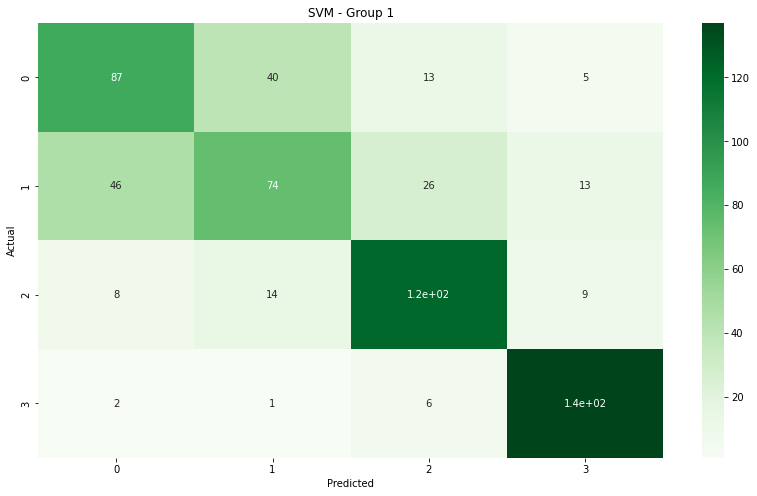

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7095721163455012; Accuracy score = 0.7180762852404643 ; Precisison Score = 0.7092971290732485; Recall score = 0.7180762852404643


 Aggregate report 
               precision    recall  f1-score   support

           0       0.64      0.71      0.67       147
           1       0.60      0.45      0.51       150
           2       0.77      0.77      0.77       151
           3       0.83      0.94      0.88       155

    accuracy                           0.72       603
   macro avg       0.71      0.72      0.71       603
weighted avg       0.71      0.72      0.71       603



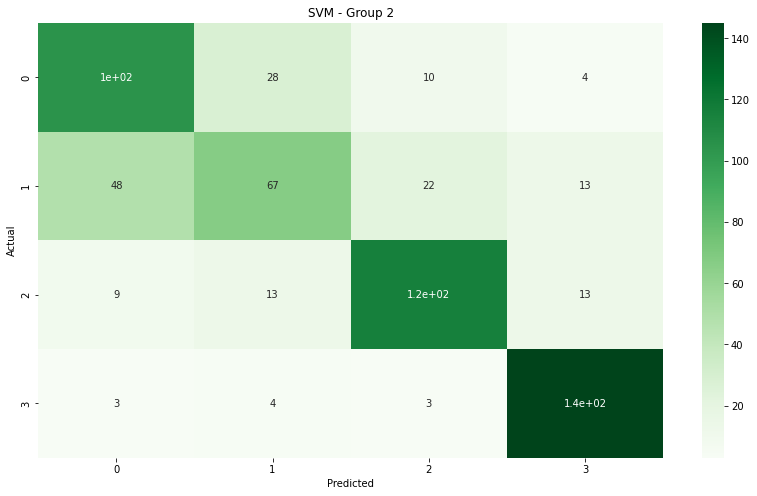

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7446261631089217; Accuracy score = 0.76 ; Precisison Score = 0.7696636363636364; Recall score = 0.76


 Aggregate report 
               precision    recall  f1-score   support

           0       0.75      0.53      0.62        17
           1       0.82      1.00      0.90        18
           2       0.68      1.00      0.81        17
           3       0.81      0.57      0.67        23

    accuracy                           0.76        75
   macro avg       0.77      0.77      0.75        75
weighted avg       0.77      0.76      0.74        75



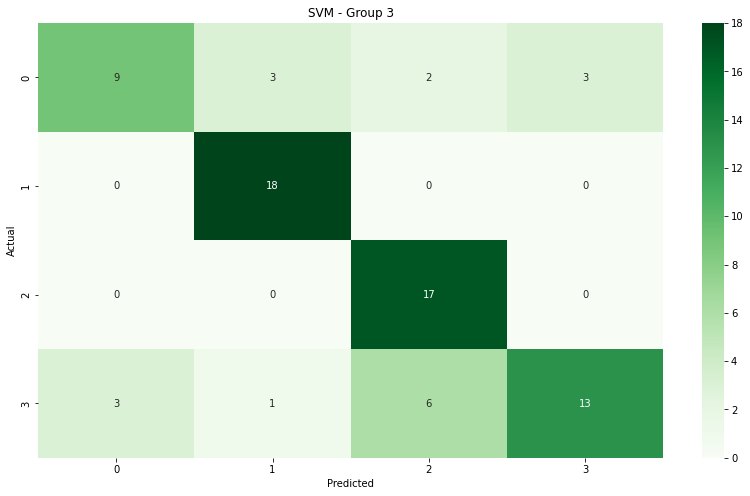

In [62]:
#lst_data_np = [data_np, data_non_noisy_np, data_noisy_np]
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
kernel = ['rbf','rbf','poly']
gamma = ['auto', 'scale', 'auto']
c = [100000, 1000, 1000]

for i in range(3):
    svm_model = svm.SVC(kernel='rbf', gamma=gamma[i], C=c[i])
    actual, predicted, X_test_list[i] = run_model(svm_model, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"SVM - Group {i+1}", actual, predicted, ['0', '1', '2', '3'])



 Aggregate report 
               precision    recall  f1-score   support

           0       0.65      0.50      0.57        64
           1       0.43      0.38      0.40        52
           2       0.59      0.78      0.67        50
           3       0.75      0.81      0.78        47

    accuracy                           0.61       213
   macro avg       0.60      0.62      0.60       213
weighted avg       0.60      0.61      0.60       213



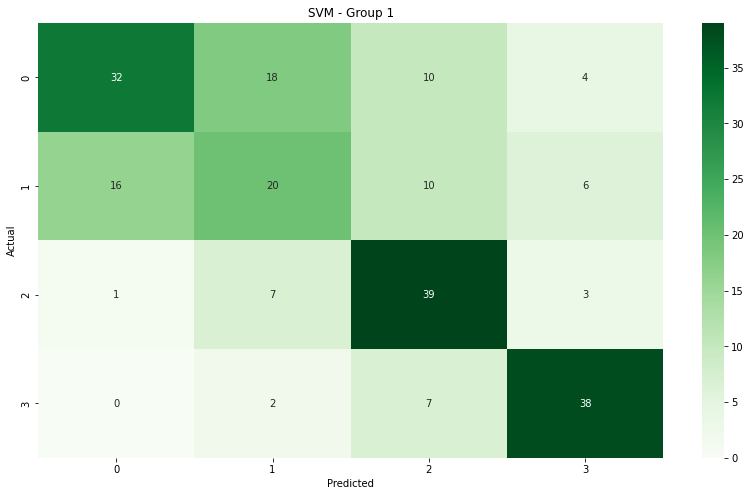



 Aggregate report 
               precision    recall  f1-score   support

           0       0.73      0.72      0.72        60
           1       0.50      0.40      0.44        48
           2       0.60      0.74      0.66        46
           3       0.76      0.76      0.76        50

    accuracy                           0.66       204
   macro avg       0.65      0.65      0.65       204
weighted avg       0.65      0.66      0.65       204



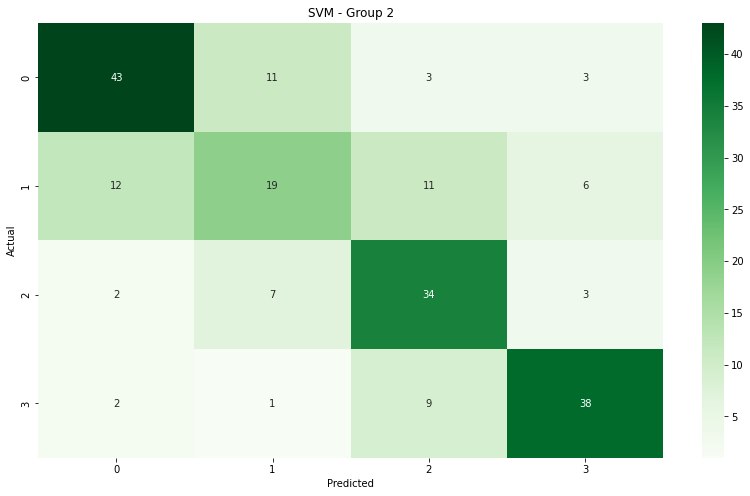



 Aggregate report 
               precision    recall  f1-score   support

           0       1.00      0.50      0.67        12
           1       0.50      1.00      0.67         4
           2       0.27      0.60      0.37         5
           3       0.73      0.53      0.62        15

    accuracy                           0.58        36
   macro avg       0.62      0.66      0.58        36
weighted avg       0.73      0.58      0.60        36



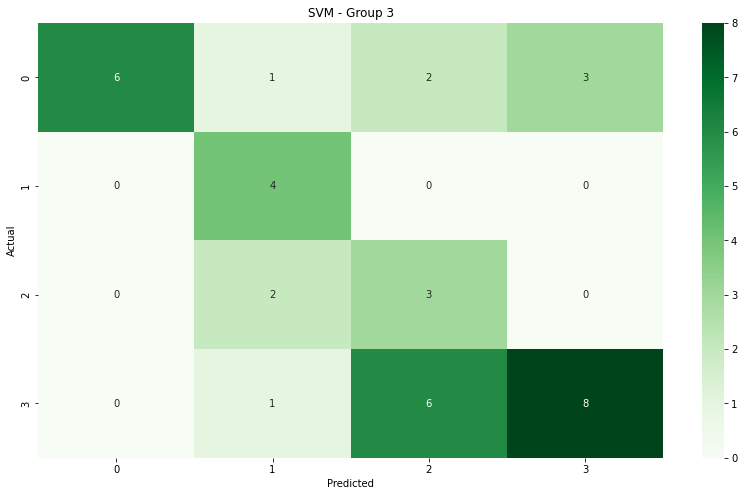

,parent_file_train,parent_label_train,segment_predictions
0,00g8dfgpqpt62,0,3
1,01avx2fm1t961,3,3
2,0202on89vhz61,0,3
3,03mglec8fez51,1,1
4,0653ipqy7vd71,2,2
...,...,...,...
208,xan1gwbxrwc61,0,2
209,xc76oggvh2471,1,2
210,xda96lajcd871,0,0
211,xdz15thrnem51,2,2


In [63]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

max_parent_df_list[0]    

#### KNN

In [59]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier()
# knn.fit(X, y)
# KNeighborsClassifier()
k_range = list(range(1, 31))

In [63]:
# original_parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': ['scale', 'auto'],
#                    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1,2,3,4,5,6]}

quick_parameters = {'n_neighbors':k_range, 'weights': ['uniform','distance'],
                    'metric': ['euclidean', 'manhattan'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'leaf_size':k_range}
hyperparameter_tuning(knn, data_balanced_np, label_balanced_np, quick_parameters)

{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}


In [64]:
quick_parameters = {'n_neighbors':k_range, 'weights': ['uniform','distance'],
                    'metric': ['euclidean', 'manhattan'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'leaf_size':k_range}
hyperparameter_tuning(knn, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)

{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}


In [65]:
#up to 10,000 was tested, but it takes a very long time to run, so we dropped it to test the degrees
quick_parameters = {'n_neighbors':k_range, 'weights': ['uniform','distance'],
                    'metric': ['euclidean', 'manhattan'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'leaf_size':k_range}
hyperparameter_tuning(knn, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}


Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6858457882104708; Accuracy score = 0.6981757877280266 ; Precisison Score = 0.6909190324180591; Recall score = 0.6981757877280266


 Aggregate report 
               precision    recall  f1-score   support

           0       0.62      0.57      0.59       148
           1       0.65      0.45      0.54       165
           2       0.67      0.87      0.75       134
           3       0.82      0.93      0.87       156

    accuracy                           0.70       603
   macro avg       0.69      0.71      0.69       603
weighted avg       0.69      0.70      0.69       603



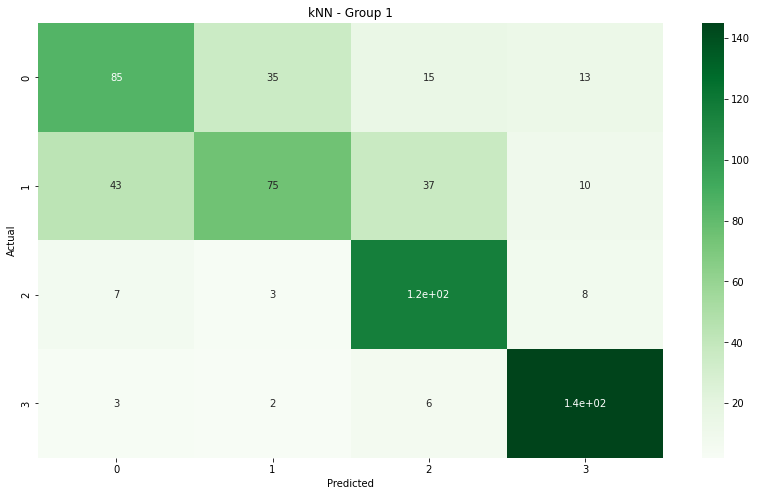

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6960959253488115; Accuracy score = 0.7078464106844741 ; Precisison Score = 0.6985315023744456; Recall score = 0.7078464106844741


 Aggregate report 
               precision    recall  f1-score   support

           0       0.64      0.56      0.60       165
           1       0.64      0.50      0.56       166
           2       0.67      0.86      0.75       132
           3       0.86      0.99      0.92       136

    accuracy                           0.71       599
   macro avg       0.70      0.73      0.71       599
weighted avg       0.70      0.71      0.70       599



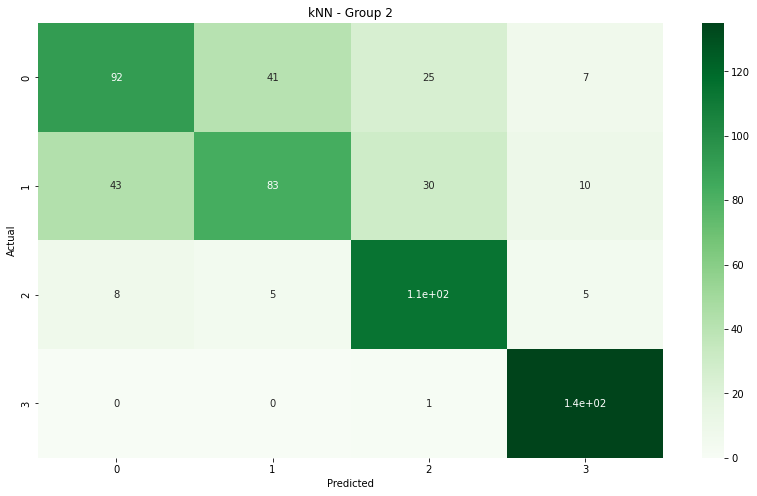

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.869572217378669; Accuracy score = 0.8666666666666667 ; Precisison Score = 0.876495814700149; Recall score = 0.8666666666666667


 Aggregate report 
               precision    recall  f1-score   support

           0       0.89      0.84      0.86        19
           1       1.00      1.00      1.00        21
           2       0.89      0.81      0.85        21
           3       0.65      0.79      0.71        14

    accuracy                           0.87        75
   macro avg       0.86      0.86      0.86        75
weighted avg       0.88      0.87      0.87        75



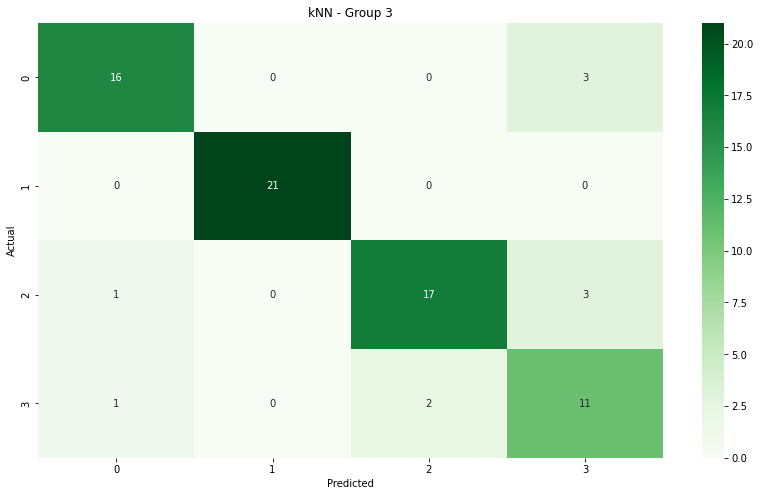

In [69]:
#lst_data_np = [data_np, data_non_noisy_np, data_noisy_np]
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
metric = ['manhattan','manhattan','euclidean']

for i in range(3):
    knn = KNeighborsClassifier(n_neighbors= 1,algorithm='auto',leaf_size= 1, metric= metric[i],weights='uniform')
    actual, predicted, X_test_list[i] = run_model(knn, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"kNN - Group {i+1}", actual, predicted, ['0', '1', '2', '3'])



 Aggregate report 
               precision    recall  f1-score   support

           0       0.68      0.52      0.59        52
           1       0.63      0.46      0.53        52
           2       0.52      0.73      0.61        45
           3       0.65      0.76      0.70        49

    accuracy                           0.61       198
   macro avg       0.62      0.62      0.61       198
weighted avg       0.62      0.61      0.61       198



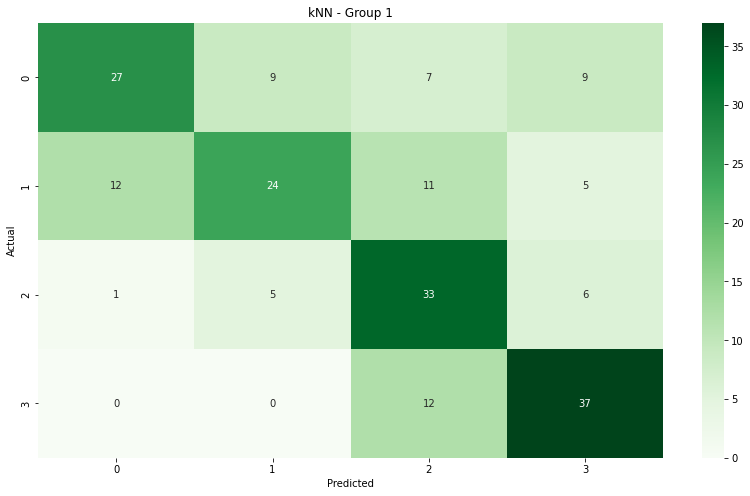



 Aggregate report 
               precision    recall  f1-score   support

           0       0.55      0.52      0.53        46
           1       0.58      0.38      0.46        50
           2       0.50      0.70      0.58        44
           3       0.68      0.69      0.68        39

    accuracy                           0.56       179
   macro avg       0.57      0.57      0.56       179
weighted avg       0.57      0.56      0.56       179



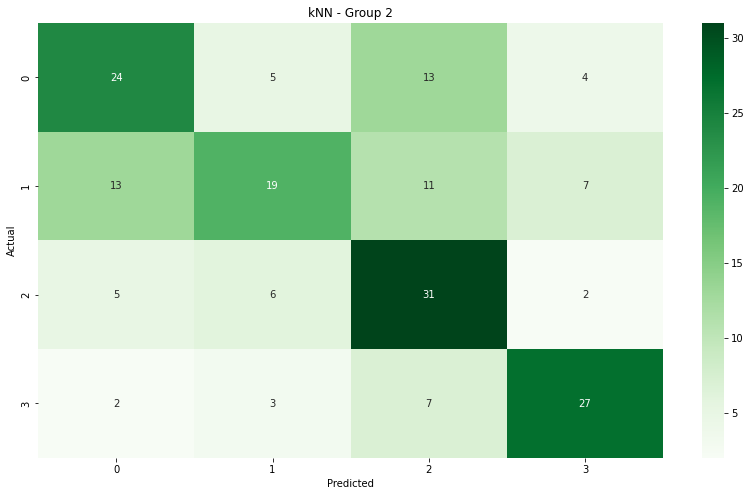



 Aggregate report 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.75      0.60      0.67         5
           2       0.33      0.67      0.44         3
           3       0.71      0.67      0.69        15

    accuracy                           0.75        36
   macro avg       0.70      0.71      0.69        36
weighted avg       0.79      0.75      0.76        36



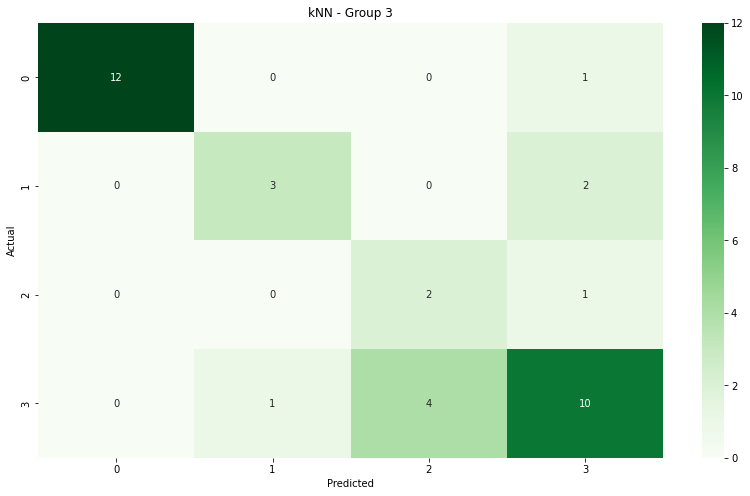

,parent_file_train,parent_label_train,segment_predictions
0,01avx2fm1t961,3,3
1,03mglec8fez51,1,2
2,0653ipqy7vd71,2,2
3,065hfyuu0ya61,0,0
4,095x9borh0z61,2,2
...,...,...,...
193,wunn1jjbpu961,0,0
194,wunqa6kfsvx51,0,2
195,xan1gwbxrwc61,0,0
196,xbw64yf04th51,1,1


In [70]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"kNN - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

max_parent_df_list[0]    

### test both balancing the data and combining levels 1 and 2

In [44]:
print(standardized_aggression_mergedlabels_df.shape)

(2110, 14)


In [45]:
# Separate classes
level0 = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 0]
level1 = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 1]
level2 = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(915, 14)
(976, 14)
(219, 14)


In [46]:
#level0 close enough

#level1 close enough

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=900)

print(level0.shape)
print(level1.shape)
print(level2.shape)

# Combine
standardized_aggression_mergedlabels_df_balanced = pd.concat([level0, level1, level2])

(915, 14)
(976, 14)
(900, 14)


In [47]:
print(standardized_aggression_mergedlabels_df_balanced.shape)

(2791, 14)


In [48]:
level0 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['segment_label_train'] == 0]
level1 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['segment_label_train'] == 1]
level2 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

#check parent label balance

level0 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['parent_label_train'] == 0]
level1 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['parent_label_train'] == 1]
level2 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['parent_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(915, 14)
(976, 14)
(900, 14)
(536, 14)
(956, 14)
(1299, 14)


non noisy

In [49]:
print(standardized_mergedlabels_non_noisy_df.shape)

(1848, 14)


In [50]:
# Separate classes
level0 = standardized_mergedlabels_non_noisy_df.loc[standardized_mergedlabels_non_noisy_df['segment_label_train'] == 0]
level1 = standardized_mergedlabels_non_noisy_df.loc[standardized_mergedlabels_non_noisy_df['segment_label_train'] == 1]
level2 = standardized_mergedlabels_non_noisy_df.loc[standardized_mergedlabels_non_noisy_df['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(778, 14)
(924, 14)
(146, 14)


In [51]:
#level0 close enough

#level1 close enough
# Downsample 0 class
level1 = resample(level1, replace=False,n_samples=775)

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=775)

print(level0.shape)
print(level1.shape)
print(level2.shape)

# Combine
standardized_mergedlabels_non_noisy_df_balanced = pd.concat([level0, level1, level2])

(778, 14)
(775, 14)
(775, 14)


In [52]:
print(standardized_mergedlabels_non_noisy_df_balanced.shape)

(2328, 14)


In [53]:
level0 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['segment_label_train'] == 0]
level1 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['segment_label_train'] == 1]
level2 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

#check parent label balance

level0 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['parent_label_train'] == 0]
level1 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['parent_label_train'] == 1]
level2 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['parent_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(778, 14)
(775, 14)
(775, 14)
(418, 14)
(805, 14)
(1105, 14)


noisy

In [54]:
print(standardized_mergedlabels_noisy_df.shape)

(262, 14)


In [55]:
# Separate classes
level0 = standardized_mergedlabels_noisy_df.loc[standardized_mergedlabels_noisy_df['segment_label_train'] == 0]
level1 = standardized_mergedlabels_noisy_df.loc[standardized_mergedlabels_noisy_df['segment_label_train'] == 1]
level2 = standardized_mergedlabels_noisy_df.loc[standardized_mergedlabels_noisy_df['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(137, 14)
(52, 14)
(73, 14)


In [56]:
# Downsample 0 class
level0 = resample(level0, replace=False,n_samples=75)

#Upsample 2 class
level1 = resample(level1, replace=True, n_samples=75)

#level3 is close enough

print(level0.shape)
print(level1.shape)
print(level2.shape)

# Combine
standardized_mergedlabels_noisy_df_balanced = pd.concat([level0, level1, level2])

(75, 14)
(75, 14)
(73, 14)


In [57]:
print(standardized_mergedlabels_noisy_df_balanced.shape)

(223, 14)


In [58]:
level0 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['segment_label_train'] == 0]
level1 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['segment_label_train'] == 1]
level2 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

#check parent label balance

level0 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['parent_label_train'] == 0]
level1 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['parent_label_train'] == 1]
level2 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['parent_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(75, 14)
(75, 14)
(73, 14)
(62, 14)
(50, 14)
(111, 14)


rebuild the svm

In [59]:
data_balanced_merged_np = standardized_aggression_mergedlabels_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_merged_np = standardized_aggression_mergedlabels_df_balanced['segment_label_train'].to_numpy()
label_balanced_merged_np=label_balanced_merged_np.astype('int')

data_balanced_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df_balanced['segment_label_train'].to_numpy()
label_balanced_merged_non_noisy_np=label_balanced_merged_non_noisy_np.astype('int')

data_balanced_merged_noisy_np = standardized_mergedlabels_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_merged_noisy_np = standardized_mergedlabels_noisy_df_balanced['segment_label_train'].to_numpy()
label_balanced_merged_noisy_np=label_balanced_merged_noisy_np.astype('int')

C:\Users\Paige\AppData\Local\Temp\ipykernel_10700\4173322112.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_merged_np = standardized_aggression_mergedlabels_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\Paige\AppData\Local\Temp\ipykernel_10700\4173322112.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\Paige\AppData\Local\Temp\ipykernel_10700\4173322112.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_merged_noisy_np = st

In [286]:
# original_parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': ['scale', 'auto'],
#                    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1,2,3,4,5,6]}

quick_parameters = {'C': [0.01, 0.1, 1, 10], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
hyperparameter_tuning(svc, data_balanced_merged_np, label_balanced_merged_np, quick_parameters)
hyperparameter_tuning(svc, data_balanced_merged_non_noisy_np, label_balanced_merged_non_noisy_np, quick_parameters)
hyperparameter_tuning(svc, data_balanced_merged_noisy_np, label_balanced_merged_noisy_np, quick_parameters)

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7052997420381426; Accuracy score = 0.7063037249283668 ; Precisison Score = 0.7077463532542837; Recall score = 0.7063037249283668


 Aggregate report 
               precision    recall  f1-score   support

           0       0.73      0.63      0.68       243
           1       0.62      0.66      0.64       248
           2       0.79      0.85      0.82       207

    accuracy                           0.71       698
   macro avg       0.71      0.71      0.71       698
weighted avg       0.71      0.71      0.71       698



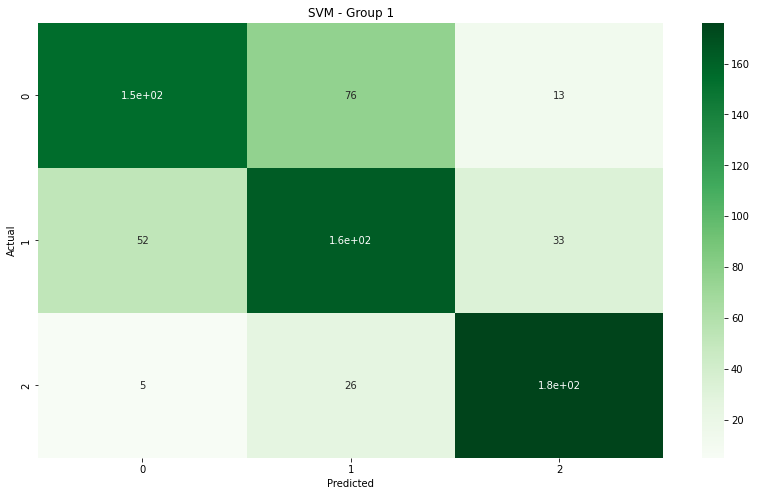

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7546679251823717; Accuracy score = 0.7577319587628866 ; Precisison Score = 0.7557098774572135; Recall score = 0.7577319587628866


 Aggregate report 
               precision    recall  f1-score   support

           0       0.78      0.70      0.74       203
           1       0.67      0.66      0.66       192
           2       0.81      0.93      0.86       187

    accuracy                           0.76       582
   macro avg       0.76      0.76      0.76       582
weighted avg       0.76      0.76      0.75       582



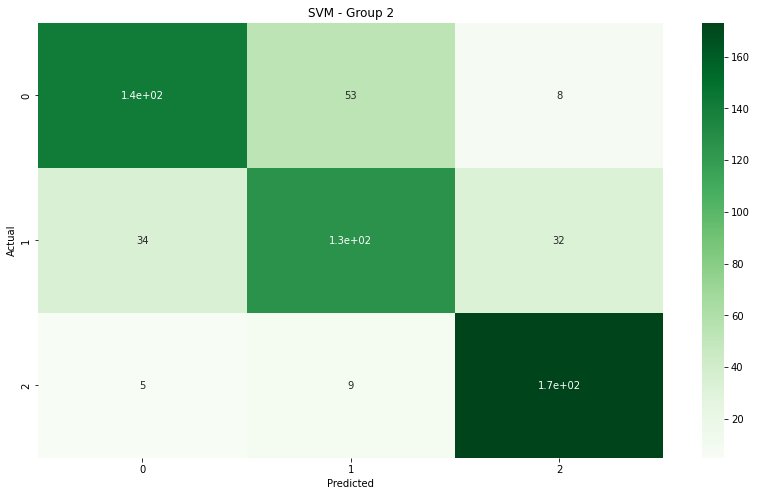

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6955042332011574; Accuracy score = 0.6964285714285714 ; Precisison Score = 0.7012533274179237; Recall score = 0.6964285714285714


 Aggregate report 
               precision    recall  f1-score   support

           0       0.79      0.65      0.71        17
           1       0.63      0.63      0.63        19
           2       0.70      0.80      0.74        20

    accuracy                           0.70        56
   macro avg       0.70      0.69      0.70        56
weighted avg       0.70      0.70      0.70        56



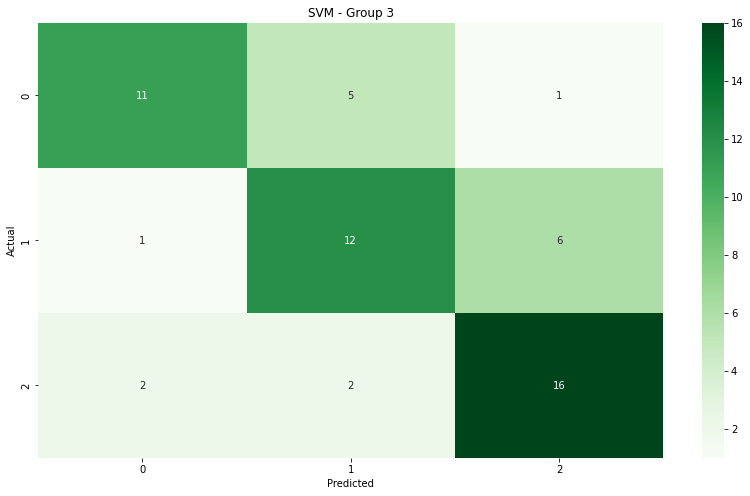

In [60]:
#lst_data_np = [data_np, data_non_noisy_np, data_noisy_np]
lst_label_np = [label_balanced_merged_np, label_balanced_merged_non_noisy_np, label_balanced_merged_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_mergedlabels_df_balanced, standardized_mergedlabels_non_noisy_df_balanced, standardized_mergedlabels_noisy_df_balanced]
X_test_list = [None,None,None]
gamma = ['auto', 'scale', 'auto']

for i in range(3):
    svm_model = svm.SVC(kernel='rbf', gamma=gamma[i], C=10)
    actual, predicted, X_test_list[i] = run_model(svm_model, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"SVM - Group {i+1}", actual, predicted, ['0', '1', '2'])



 Aggregate report 
               precision    recall  f1-score   support

           0       0.64      0.56      0.60        66
           1       0.62      0.62      0.62        87
           2       0.67      0.76      0.71        55

    accuracy                           0.64       208
   macro avg       0.64      0.65      0.64       208
weighted avg       0.64      0.64      0.64       208



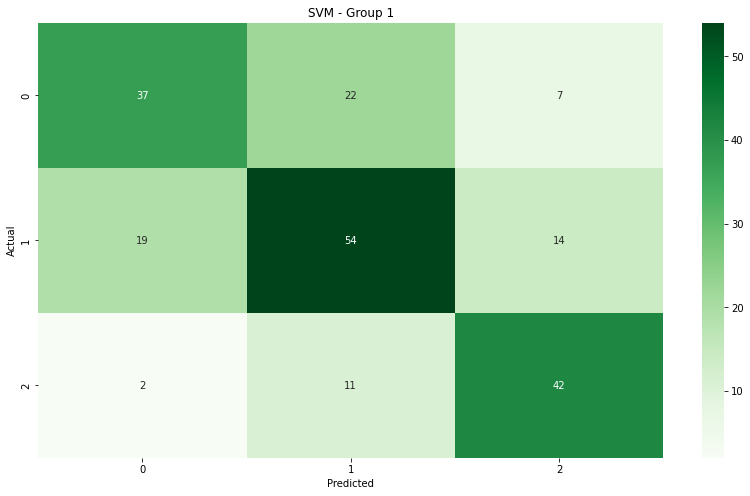



 Aggregate report 
               precision    recall  f1-score   support

           0       0.49      0.49      0.49        47
           1       0.68      0.61      0.65        83
           2       0.62      0.76      0.68        37

    accuracy                           0.61       167
   macro avg       0.60      0.62      0.61       167
weighted avg       0.61      0.61      0.61       167



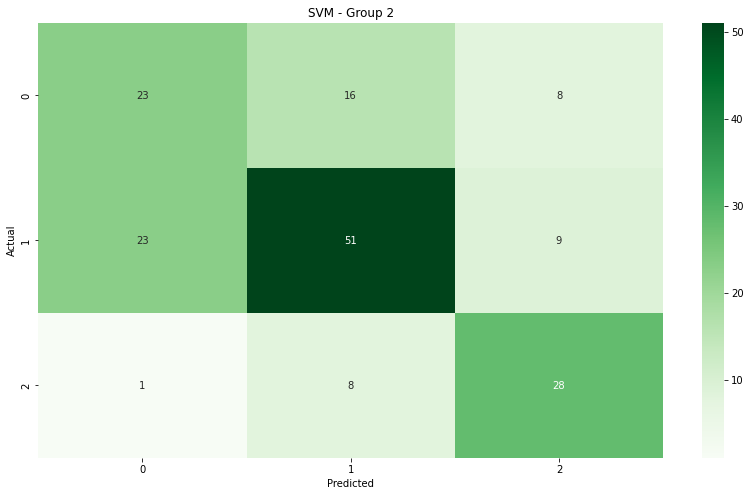



 Aggregate report 
               precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.43      0.75      0.55         8
           2       0.75      0.50      0.60        12

    accuracy                           0.56        32
   macro avg       0.59      0.58      0.56        32
weighted avg       0.61      0.56      0.57        32



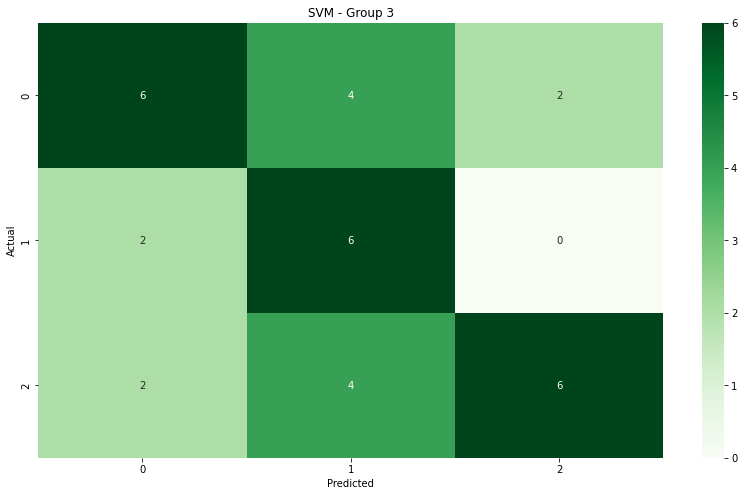

,parent_file_train,parent_label_train,segment_predictions
0,00g8dfgpqpt61,0,2
1,01avx2fm1t961,2,1
2,03mglec8fez51,1,1
3,0653ipqy7vd71,1,2
4,065hfyuu0ya61,0,1
...,...,...,...
203,wunqa6kfsvx51,0,1
204,xan1gwbxrwc61,0,0
205,xbw64yf04th51,1,0
206,xdz15thrnem51,1,2


In [290]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2'])

max_parent_df_list[0]    

perhaps for noisy because everything is so loud we can only get binary classification?

In [294]:
standardized_aggression_binary_df = standardized_aggression_df.copy()
standardized_binary_noisy_df = standardized_aggression_binary_df.loc[standardized_aggression_binary_df['noisy_train'] == 1]
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 1, 'segment_label_train' ] = 0
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 2, 'segment_label_train'] = 1
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 3, 'segment_label_train'] = 1
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['parent_label_train'] == 1, 'parent_label_train'] = 0
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['parent_label_train'] == 3, 'parent_label_train'] = 1
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['parent_label_train'] == 2, 'parent_label_train'] = 1
print(standardized_binary_noisy_df['segment_label_train'].unique())
print(standardized_binary_noisy_df['parent_label_train'].unique())

C:\Users\Paige\AppData\Local\Temp\ipykernel_10828\2694918186.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 1, 'segment_label_train' ] = 0
C:\Users\Paige\AppData\Local\Temp\ipykernel_10828\2694918186.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 2, 'segment_label_train'] = 1
C:\Users\Paige\AppData\Local\Temp\ipykernel_10828\2694918186.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

[0 1]
[0 1]


In [295]:
data_binary_noisy_np = standardized_binary_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_binary_noisy_np = standardized_binary_noisy_df['segment_label_train'].to_numpy()
label_binary_noisy_np=label_binary_noisy_np.astype('int')

C:\Users\Paige\AppData\Local\Temp\ipykernel_10828\524940715.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_binary_noisy_np = standardized_binary_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()


In [296]:
quick_parameters = {'C': [ 0.001, 0.01, 0.1, 1, 10, 100], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
hyperparameter_tuning(svc, data_binary_noisy_np, label_binary_noisy_np, quick_parameters)

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

In [299]:
# Separate classes
level0 = standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 0]
level1 = standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 1]

print(level0.shape)
print(level1.shape)

(156, 14)
(106, 14)


already pretty balanced no need to change it

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.8190362269309637; Accuracy score = 0.8181818181818182 ; Precisison Score = 0.821401338642718; Recall score = 0.8181818181818182


 Aggregate report 
               precision    recall  f1-score   support

           0       0.86      0.82      0.84        39
           1       0.76      0.81      0.79        27

    accuracy                           0.82        66
   macro avg       0.81      0.82      0.81        66
weighted avg       0.82      0.82      0.82        66



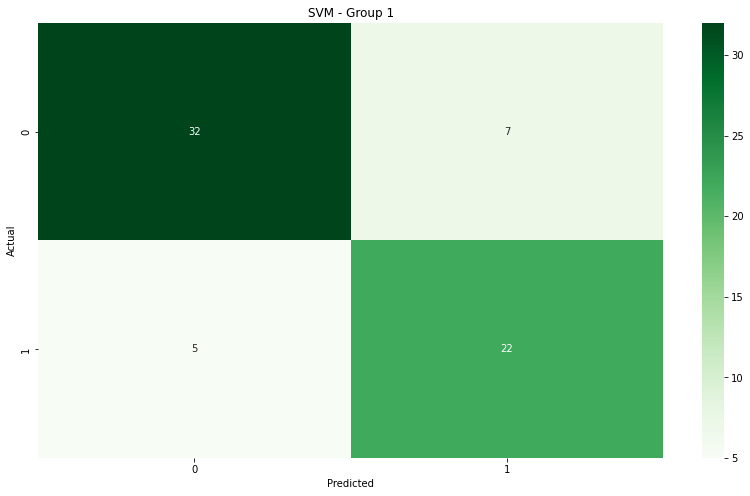

In [303]:
label = 'segment_label_train'
X_test_list = [None]

svm_model = svm.SVC(kernel='linear', gamma='scale', C=0.1)
actual, predicted, X_test_list[0] = run_model(svm_model, standardized_binary_noisy_df,  label_binary_noisy_np,label_name=label)

confusion_matrix_graph(f"SVM - Group {i+1}", actual, predicted, ['0', '1'])



 Aggregate report 
               precision    recall  f1-score   support

           0       0.79      0.71      0.75        21
           1       0.65      0.73      0.69        15

    accuracy                           0.72        36
   macro avg       0.72      0.72      0.72        36
weighted avg       0.73      0.72      0.72        36



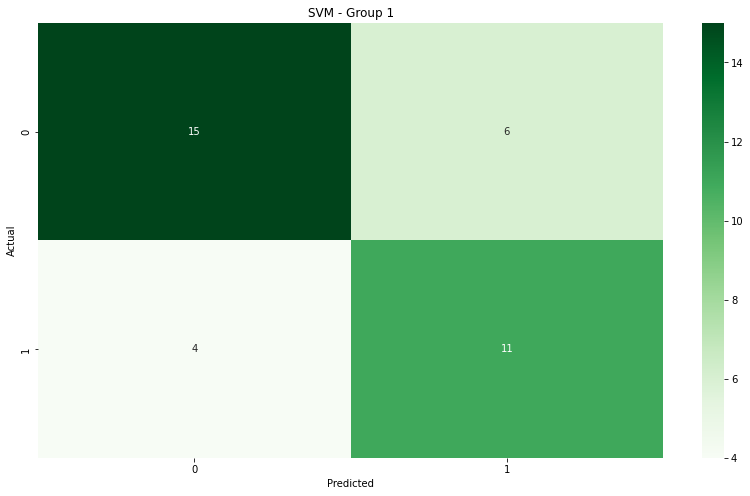

,parent_file_train,parent_label_train,segment_predictions
0,01avx2fm1t961,1,1
1,143mdsnmvu461,1,1
2,16dnw24q0jo51,0,0
3,1fhp1vuk9h461,0,0
4,1sm6gyfaqyb71,1,1
5,37gpiutnlqj51,0,0
6,3duf3yestck51,1,1
7,3nr00989hhp51,1,0
8,3nvn1lwacgg61,0,0
9,hv7owj844s461,1,1


In [304]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1'])

max_parent_df_list[0]

This seems to be the way to go for noisy, middle levels cannot be teased out with the background sound and overlapping voices

## Conclusions:

### We can get slightly better models (approx 8%) by combining the levels, however, this is further from our original research question and it is more interesting to classify both noisy and non-noisy with the same levels. Because of this we will select balanced sampled original (4 class) classification, to conintue onto the other models

# XG BOOST model